In [1]:
import sys
import os
sys.path.append('/Users/cosinga/code/sparta_dev/analysis/build/lib/')
from sparta_tools import moria, sparta
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

# paths
BASE = '/Users/cosinga/code/'
SIMPATH = '/Users/cosinga/sims/sparta_output/'
MORIA_FILE = 'moria_tree_cbol_l0063_n0256_no_cuts.hdf5'
SIMNAME = 'L0063_N0256_CBol'
SPARTA_FILE = 'sparta_no_cuts.hdf5'

# verbosity - 1 includes print statemtents, 
# 2 breaks after one halo (with at least one tracer)
V = 2
V_COUNT = 50
# desired quantities
RADIUS_DEF = 'R200m_all_spa_internal'
MASS_DEF = 'M' + RADIUS_DEF[1:]
mdata = moria.load(
    SIMPATH + '%s/%s'%(SIMNAME, MORIA_FILE), 
    [RADIUS_DEF, MASS_DEF, 'mask_alive', 'x', 'id',
     'phantom', 'parent_id_cat', 'parent_id_orbinf',
     'scale_of_last_MM']
)

sdata = sparta.load(
    SIMPATH + '%s/%s'%(SIMNAME, SPARTA_FILE), load_halo_data = True,
    anl_match = ['hps', 'rsp'], anl_pad_unmatched = True,
    res_match = ['ifl', 'oct', 'tjy'], res_pad_unmatched = True
)

updated version
sparta.load: Loading file /Users/cosinga/sims/sparta_output/L0063_N0256_CBol/sparta_no_cuts.hdf5.
sparta.load: Loading 38867/38867 halos from SPARTA file (entire array)...
sparta.load: Matching result IDs in tracer sho, halo 3887/38867
sparta.load: Matching result IDs in tracer sho, halo 7773/38867
sparta.load: Matching result IDs in tracer sho, halo 11659/38867
sparta.load: Matching result IDs in tracer sho, halo 15545/38867
sparta.load: Matching result IDs in tracer sho, halo 19431/38867
sparta.load: Matching result IDs in tracer sho, halo 23317/38867
sparta.load: Matching result IDs in tracer sho, halo 27203/38867
sparta.load: Matching result IDs in tracer sho, halo 31089/38867
sparta.load: Matching result IDs in tracer sho, halo 34975/38867
sparta.load: Matching result IDs in tracer sho, halo 38861/38867


In [12]:
# renaming symbols
tjy = sdata['tcr_sho']['res_tjy']
ifl = sdata['tcr_sho']['res_ifl']
oct = sdata['tcr_sho']['res_oct']
hdata = sdata['halos']
boxsize = sdata['simulation']['box_size']
nhalos = len(hdata['sho_oct_first'])
nsnaps = sdata['simulation']['n_snaps']
snap_z = sdata['simulation']['snap_z']
snap_a = sdata['simulation']['snap_a']
res_lim = 200 * sdata['simulation']['particle_mass']
snaps = np.arange(nsnaps)
ntcrs = tjy.shape[0]

In [3]:


if not os.path.exists("htXps.pkl"):
    raise ValueError("pickle file not created...")

else:
    htXps = pkl.load(open("htXps.pkl", 'rb'))

# Investigating the host-tracer pairs that are not parent-subhalo.

Tasks:
- get pure number of pairs / total pairs at each snapshot, and in different mass bins. Also plot for tracers that have already had a pericenter.
- Do these pairs exist in the raw catalogs? What time does ROCKSTAR call these subhalos?
- Create mask for tracers that belong to this population for later analyses.
- Plot the phi values until the pericenter is detected. Test with different r_ini values (going to further back snapshots).
        

Text(0, 0.5, 'count')

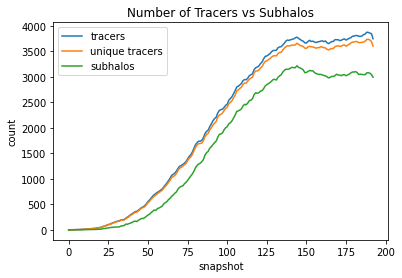

In [8]:
# total number of tracers vs subhalos
tcr_count = np.zeros(nsnaps)
tcr_unique_count = np.zeros(nsnaps)
sub_count = np.zeros(nsnaps)
for i in range(nsnaps):
    tcr_mask = ((tjy['first_snap'] <= i) & (tjy['last_snap'] >= i))
    tcr_count[i] = tcr_mask.sum()
    unique_tcrids = np.unique(tjy['tracer_id'][tcr_mask])
    tcr_unique_count[i] = len(unique_tcrids)
    sub_count[i] = (mdata['parent_id_cat'][i, :] > 0).sum()

plt.plot(snaps, tcr_count, label = 'tracers')
plt.plot(snaps, tcr_unique_count, label = 'unique tracers')
plt.plot(snaps, sub_count, label = 'subhalos')
plt.legend()
plt.title("Number of Tracers vs Subhalos")
plt.xlabel("snapshot")
plt.ylabel("count")


The above plot confirms that there are more tracers than there are subhalos, and that the difference between the two cannot be accounted for by tracer ID copies which arise from one tracer entering $R_{200m}$ of two different parent halos. Therefore, this implies that there is some fraction of host-tracer pairs that do not have parent-subhalo pairs. It seems that maybe >75% of all tracers are also subhalos.

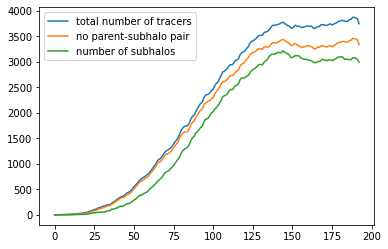

In [9]:
# fraction of missing pairs
tcr_count = np.zeros(nsnaps)
htxps_count = np.zeros(nsnaps)
sub_count = np.zeros(nsnaps)
for i in range(nsnaps):
    tcr_mask = ((tjy['first_snap'] <= i) & (tjy['last_snap'] >= i))
    tcr_count[i] = tcr_mask.sum()
    htxps_count[i] = (tcr_mask & htXps['htXps']).sum()
    sub_count[i] = (mdata['parent_id_cat'][i, :] > 0).sum()

plt.plot(snaps, tcr_count, label = 'total number of tracers')
plt.plot(snaps, htxps_count, label = 'no parent-subhalo pair')
plt.plot(snaps, sub_count, label = 'number of subhalos')
plt.legend()

In [10]:
# do any subhalos have no tracers?
has_tracer = np.zeros(nhalos)
for i in range(nhalos):
    # if this halo is a subhalo
    is_sub = mdata['parent_id_cat'][:, i] > 0
    is_alive = mdata['mask_alive'][:, i]
    if np.any(is_sub):
        sub_ids = mdata['id'][is_alive, i]
        in_mask = np.isin(sub_ids, tjy['tracer_id'])
        has_tracer[i] = np.any(in_mask)

    else:
        has_tracer[i] = -1 # not a sub



In [11]:
print((has_tracer == 0).sum())

716


/var/folders/79/98r4p1nd3v19cl5z3dbndg_c0000gn/T/ipykernel_12745/1957359391.py:12: RuntimeWarning: invalid value encountered in long_scalars
  htXps_frac[i] = htXps_count / tcr_count


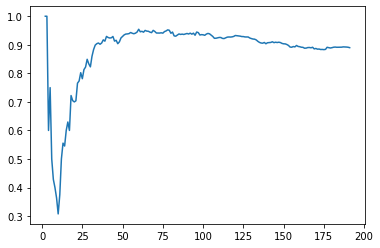

In [5]:
# total number of 

tcr_snaps = np.where(htXps['is_tcr'])[1]
tcr_int_snaps = np.where(htXps['is_tcr_interp'])[1]

# plot of error tracers over total number at each snapshot
htXps_frac = np.zeros(nsnaps)
for i in range(nsnaps):

    htXps_count = (tcr_snaps == i).sum()
    tcr_count = ((tjy['first_snap'] <= i) & (tjy['last_snap'] > i)).sum()
    htXps_frac[i] = htXps_count / tcr_count

plt.plot(htXps_frac)

In [9]:
rstree = np.loadtxt('/Users/cosinga/sims/nbody/cbol_l0063_n0256/rockstar_trees_200m_bnd/tree_0_0_0.dat')
rstree.shape

(2704376, 60)

In [14]:
np.sum(mdata['mask_alive'])

2704376

In [18]:
import re
f = open('/Users/cosinga/sims/nbody/cbol_l0063_n0256/rockstar_trees_200m_bnd/tree_0_0_0.dat', 'r')
line = f.readline()
line = re.sub(r'\(\d+\)', '', line)
head = line[1:].split(' ')
head

['scale',
 'id',
 'desc_scale',
 'desc_id',
 'num_prog',
 'pid',
 'upid',
 'desc_pid',
 'phantom',
 'sam_M200b',
 'M200b',
 'R200b',
 'rs',
 'vrms',
 'mmp?',
 'scale_of_last_MM',
 'vmax',
 'x',
 'y',
 'z',
 'vx',
 'vy',
 'vz',
 'Jx',
 'Jy',
 'Jz',
 'Spin',
 'Breadth_first_ID',
 'Depth_first_ID',
 'Tree_root_ID',
 'Orig_halo_ID',
 'Snap_idx',
 'Next_coprogenitor_depthfirst_ID',
 'Last_progenitor_depthfirst_ID',
 'Last_mainleaf_depthfirst_ID',
 'Tidal_Force',
 'Tidal_ID',
 'Rs_Klypin',
 'M200b_all',
 'Mvir',
 'M200c',
 'M500c',
 'M2500c',
 'Xoff',
 'Voff',
 'Spin_Bullock',
 'b_to_a',
 'c_to_a',
 'A[x]',
 'A[y]',
 'A[z]',
 'b_to_a(500c)',
 'c_to_a(500c)',
 'A[x](500c)',
 'A[y](500c)',
 'A[z](500c)',
 'T/|U|',
 'M_pe_Behroozi',
 'M_pe_Diemer',
 'Halfmass_Radius\n']